# Oppgave 2: Klassifikasjon (14 poeng)
## Del 1: Logistisk regresjon

Et populært eksempel innen klassifikasjon er implementeringen av et spamfilter. Det er noe de fleste av oss kjenner til, men har du noen gang spurt deg selv hvordan det egentlig fungerer?

Her bruker vi et datasett med 5 575 SMS-meldinger som allerede er klassifisert som enten «spam» eller «ham». Dataene er hentet fra:

https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

og den originale studien finner du her: https://dl.acm.org/doi/10.1145/2034691.2034742

Dette er til informasjon. Du trenger ikke laste noe ned eller lese dette, du får alt du trenger her i oppgaveteksten.

I denne oppgaven skal vi tilpasse en logistisk regresjonsmodell for å lage et spamfilter. 


In [14]:
# Vi begynner igjen med å importere pakker og funksjoner vi trenger i oppgaven

import pandas as pd
import numpy as np
import random

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


from sklearn.model_selection import train_test_split, cross_val_score

# plotting
import matplotlib.pyplot as plt

## Spamfilter datasett

Først leser vi inn datasettet. Vi gir nye navn til kolonnene (som skal hete 'y' og 'tekst'), koder om 'spam' til '1' og 'ham' til '0', og ser på innholdet av datasettet.


In [15]:
# Lese inn datasettet ved en funksjon fra pandas  (df=data frame - vanlig navn å gi et datasett)
df = pd.read_csv('https://www.math.ntnu.no/emner/IST100x/ISTx1003/h2021/SMSSpamCollection.txt', delimiter='\t',header=None)

# Gi nye navner til den første kolonnen (slik at den heter 'y') og den andre kolonnen (som skal hete 'text').
# y er den binære responsen som koder y=1 for "spam" og y = 0 for "ham" (=ikke spam) 
# Kolonnen 'text' inneholder SMS teksten 

df = df.rename(columns={0: 'y', 1: 'text'})

# Vi bytter at spam er 1 og ham er 0
df['y'] = df['y'].map({'spam': 1, 'ham': 0}).astype(int)

print(df)

      y                                               text
0     0  Go until jurong point, crazy.. Available only ...
1     0                      Ok lar... Joking wif u oni...
2     1  Free entry in 2 a wkly comp to win FA Cup fina...
3     0  U dun say so early hor... U c already then say...
4     0  Nah I don't think he goes to usf, he lives aro...
...  ..                                                ...
5567  1  This is the 2nd time we have tried 2 contact u...
5568  0               Will ü b going to esplanade fr home?
5569  0  Pity, * was in mood for that. So...any other s...
5570  0  The guy did some bitching but I acted like i'd...
5571  0                         Rofl. Its true to its name

[5572 rows x 2 columns]


### **Problem 2a)** (2P)

 (i) Hvor mange av SMS meldingene er spam og hvor mange er ham? Tips: Bruk en funksjon du har sett i oppgave 1 som heter `value_counts()`. 
 
 (ii) Lag et histogram for responsen $y$ ved bruk av `plt.hist()` funksjonen.

###   <font color='red'>Løsning:</font> Svar på svararket.

### Trening, validerings og testsett

Før vi fortsetter med modelleringen, skal vi dele datasettet i tre deler: et treningssett, et valideringssett og et testsett. Vi bestemmer oss her for å legge 70 % av dataene i treningssettet, og 15% i både validerings- og testsettet.

In [16]:
# Først del dataene i trenings og testsett (70-30%)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(df['text'],df['y'],test_size=0.3,random_state=10)

# Og så del testsettet igjen i et test- og et valideringssett slik at begge inneholder 15% (50% av de 30%)
X_test_raw, X_val_raw, y_test, y_val = train_test_split(X_test_raw,y_test,test_size=0.5,random_state=10)

Husk hvorfor vi må dele datasettet i disse ulike delene. Sjekk forelesningsmaterialet hvis du har glemt det.


## Logistisk regresjon


I undervisningen har vi lært at logistisk regresjon trenger forklaringsvariabler. Med to forklaringsvariabler $x_1$ og $x_2$, for eksempel, kan vi modellere sannsynligheten for en "suksess" (e.g., at en SMS melding er spam) som
$$p_i = \frac{\exp(\beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i})}{ 1 + \exp(\beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i})} \ .$$



### **Problem 2b)** (1P)

I dette eksempelet har vi en datasett med 'text' som mulige forklaringsvariable. Er dette et problem? Forklar med maks 2 setninger.

###   <font color='red'>Løsning:</font> Svar på svararket.


For at Python skal kunne arbeide med tekstmeldingene, må vi vektorisere dataene. Hva betyr det? Jo, det innebærer at vi registrerer hvert ord og hvor ofte ordet forekommer i hver SMS. Vi oppretter en matrise der hver kolonne representerer et ord, og skriver inn «1» i matrisen hvis ordet finnes i SMS-en som står i den aktuelle raden (eller «2» hvis ordet forekommer to ganger, osv.), ellers «0».

Vektoriseringen vil derfor produsere en matrise med veldig mange nuller – det finnes mange ulike ord, og de aller fleste forekommer ikke i en gitt SMS-tekst. Derfor kan vi komprimere matrisen ganske mye.

Alt dette kan vi gjøre ved hjelp av følgende kode:

In [17]:
# Vektorisering av SMS tekstene
vect = CountVectorizer()
vect.fit(X_train_raw)
x_train = vect.transform(X_train_raw)
x_test = vect.transform(X_test_raw)
x_val = vect.transform(X_val_raw)

In [18]:
# Hva betyr dette? x_train, x_test og x_val er nå komprimerte matriser, 
# hvor hver rad er en SMS og hver kolonne er et ord som finnes i de ulike SMS-meldingene. 

# Dette er komprimerte matriser, og derfor er det litt vanskelig å se på dem.
# Men vi kan prøve å se litt på en dekomprimert versjon av x_train her:
# (Obs! Men vi skal fortsette med de komprimerte versjonene x_train, x_test, x_val etterpå)
type(x_train)
print(pd.DataFrame(x_train.toarray()))

      0     1     2     3     4     5     6     7     8     9     ...  7176  \
0        0     0     0     0     0     0     0     0     0     0  ...     0   
1        0     0     0     0     0     0     0     0     0     0  ...     0   
2        0     0     0     0     0     0     0     0     0     0  ...     0   
3        0     0     0     0     0     0     0     0     0     0  ...     0   
4        0     0     0     0     0     0     0     0     0     0  ...     0   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
3895     0     0     0     0     0     0     0     0     0     0  ...     0   
3896     0     0     0     0     0     0     0     0     0     0  ...     0   
3897     0     0     0     0     0     0     0     0     0     0  ...     0   
3898     0     0     0     0     0     0     0     0     0     0  ...     0   
3899     0     0     0     0     0     0     0     0     0     0  ...     0   

      7177  7178  7179  7180  7181  7182  7183  718

### Problem 2c) (1P)

Hvor mange SMS-meldinger er det i treningsdatasettet? Hvor mange forskjellige ord finnes i disse meldingene?

###   <font color='red'>Løsning:</font> Svar på svararket.


Okei... nå har vi egentlig et problem, for vi har flere forklaringsvariabler (altså flere forskjellige ord!) enn observasjoner. Vi har ikke snakket om hvordan man bruker logistisk regresjon i et slikt tilfelle, så dere trenger ikke å forstå nøyaktig hvordan det fungerer eller hva som faktisk skjer når vi tilpasser en logistisk regresjonsmodell. (Vi bruker noe som kalles regularisering, men som sagt er det utenfor pensum.)

Det viktigste er at vi gjennomfører en logistisk regresjon med binær respons: y=0 for «ham» og  y=1 for «spam».
Det gjør vi nå for treningsdatasettet:

In [19]:
# Tilpass en logistisk regression med treningsdata:

lr = LogisticRegression(penalty='l2')
lr.fit(x_train,y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [21]:
## Og nå kan vi utregne feilraten på treningssettet:

lrscore = lr.score(x_train,y_train)
print('Logistic regression feilrate: ',round(1-lrscore,5))

Logistic regression feilrate:  0.00231


### Problem 2d) (2P)

 (i) Hvor stor er andelen av SMS-meldingene som er riktig klassifisert i treningssettet?
 
 (ii) Er feilraten i valideringssettet større eller mindre enn i treningssettet, og hvorfor? For å finne ut, kopier koden hvor vi har regnet ut feilrate på treningssettet, og erstatt trenings- med valideringssettet. Viktig: Bruk modellen som du har tilpasset til treningssettet!
 

###   <font color='red'>Løsning:</font> Svar på svararket.  (Gjerne også kopier et bilde av koden og resultatet fra jupyter notebooken.)


Vi har lært i undervisningen at logistisk regresjon predikerer sannsynligheten $p_i$ for at $y_i=1$. Klassifiseringsregelen som brukes er å forutsi $\hat{y}_i = 1$ hvis $p_i>0.5$ og ellers $y_i = 0$. Det er akkurat det som scorefunksjonen som brukes ovenfor (`lr.score`) faktisk gjør. Valget av 0.5 er imidlertid vilkårlig, og det kan være at en annen cutoff ville gi bedre prediksjoner.

### Problem 2e) (3P)

 (i) Bruk igjen modellen over som du har tilpasset til treningsdatasettet, men bruk alle cutoff-verdier 0.1, 0.2, ... 0.9 for å klassifisere observasjonene i valideringssettet (se og kjør kode under). Hvilken cutoff fungerer best og hva er den tilsvarende feilraten på valideringssettet?
 
 (ii) Nå kan du bruke den beste cutoff-verdien og regne ut feilraten på testsettet. Tilpass koden.
 
 (iii) Hvorfor er det ikke rart at testsettet gir en litt høyere feilrate enn på både trenings og valideringssettet? Maks 2 setninger.
 
###   <font color='red'>Løsning:</font> Svar på svararket.  (Gjerne også kopier et bilde av koden og resultatet fra jupyter notebooken.)


In [22]:
# For å få sannsynlighet P(y=1) for at en SMS var spam
val_prob = lr.predict_proba(X=x_val)[:,[1]]

# Og nå klassifiser med forskjellige cutoff verdier mellom 0.1 og 0.9:
for x in np.arange(0.1, 1.0, 0.1):
    cutoff = x
    # Prediker spam eller ham avhengig av P(y=1)
    y_valpred = np.where(val_prob > cutoff, 1, 0)

    # Finn andel korrekte klassifikasjoner
    print("cutoff:", round(x,1), "Accuracy:", round(accuracy_score(y_true=y_val, y_pred=y_valpred),5),
      "Feilrate:", round(1-accuracy_score(y_true=y_val, y_pred=y_valpred),5))

cutoff: 0.1 Accuracy: 0.97727 Feilrate: 0.02273
cutoff: 0.2 Accuracy: 0.98325 Feilrate: 0.01675
cutoff: 0.3 Accuracy: 0.98206 Feilrate: 0.01794
cutoff: 0.4 Accuracy: 0.97727 Feilrate: 0.02273
cutoff: 0.5 Accuracy: 0.97847 Feilrate: 0.02153
cutoff: 0.6 Accuracy: 0.97727 Feilrate: 0.02273
cutoff: 0.7 Accuracy: 0.97727 Feilrate: 0.02273
cutoff: 0.8 Accuracy: 0.9701 Feilrate: 0.0299
cutoff: 0.9 Accuracy: 0.96053 Feilrate: 0.03947



## Del 2: $k$-nærmeste-nabo-klassifikasjon (KNN)

Spamfiltereksempelet kan dessverre ikke brukes til KNN-klassifikasjon. Problemet skyldes noe som kalles the curse of dimensionality, som oppstår når vi har for mange forklaringsvariabler (se https://en.wikipedia.org/wiki/Curse_of_dimensionality).

Vi skal derfor bruke et annet datasett, der vi ønsker å predikere om en person kjøper en campingvognforsikring eller ikke, avhengig av 85 forklaringsvariabler. Datasettet, som består av 5 822 observasjoner, er en del av ISLR-pakken i R. Mer informasjon finner du her: https://liacs.leidenuniv.nl/~puttenpwhvander/library/cc2000/data.html 

Forsikringsselskapet ønsker å bruke prediksjonsmodellen til å velge ut potensielle kunder de kan ringe, slik at de får solgt flere forsikringer uten å kontakte for mange personer.


In [23]:
# Vi begynner igjen med å importere pakker og funksjoner vi trenger i oppgaven

import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Trening og testsett, evaluering av klassifikasjonsmetoder 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

## Caravan datasettet

In [24]:
df = pd.read_csv('https://www.math.ntnu.no/emner/IST100x/ISTx1003/h2021/Caravan.csv', delimiter=',')

df.shape
df.describe

<bound method NDFrame.describe of        MOSTYPE  MAANTHUI   MGEMOMV  MGEMLEEF  MOSHOOFD    MGODRK    MGODPR  \
0     0.680848 -0.272557  0.406662 -1.216859  0.779338 -0.694251  0.217425   
1     0.992212 -0.272557 -0.859426 -1.216859  0.779338  0.302526 -0.365379   
2     0.992212 -0.272557 -0.859426 -1.216859  0.779338 -0.694251 -0.365379   
3    -1.187335 -0.272557  0.406662  0.010754 -0.970896  1.299302 -0.948183   
4     1.225735 -0.272557  1.672750 -1.216859  1.479432  0.302526 -0.365379   
...        ...       ...       ...       ...       ...       ...       ...   
5817  0.914371 -0.272557 -2.125514 -1.216859  0.779338 -0.694251  0.800229   
5818  0.836530 -0.272557  1.672750  1.238367  0.779338  0.302526 -0.365379   
5819  0.680848 -0.272557  0.406662  1.238367  0.779338 -0.694251  0.800229   
5820  0.758689 -0.272557  0.406662 -1.216859  0.779338 -0.694251  1.383033   
5821  0.680848 -0.272557  0.406662  0.010754  0.779338 -0.694251  0.800229   

        MGODOV    MGODGE    M

In [25]:
# Vi erstatter Yes/No variablen med 1/0 
#df.replace(('Yes', 'No'), (1, 0), inplace=True)
#df['Purchase'] = df['Purchase'].replace({'Yes': 1, 'No': 0}).astype(int)
df['Purchase'] = df['Purchase'].map({'Yes': 1, 'No': 0}).astype(int)

# Se på antall kjøpere i datasettet. 
# Vi ser at bare en liten andel av mulige kunder faktisk kjøper en forsikring:
print(df['Purchase'].value_counts())
 

Purchase
0    5474
1     348
Name: count, dtype: int64


### Problem 2f) (1P)

Hva er _andelen_ av kunder som faktisk kjøper en forsikring?
 
###   <font color='red'>Løsning:</font> Svar på svararket.

Vi fortsetter med å dele datasettet inn i et trenings- og valideringssett (vi lager ikke noe testsett for å ikke gjøre oppgaven for vanskelig).

In [26]:
# Del dataene i et trenings- og et valideringssett (60-40%)
df_tren, df_val = train_test_split(df, test_size = 0.4,random_state=1,stratify=df['Purchase'])

X_tren = df_tren.drop('Purchase',axis=1)
X_val = df_val.drop('Purchase',axis=1)

Og så tilpasser vi en $k$-nærmeste-nabo (KNN) klassifikasjon med $k$=1. Deretter ser vi på feilraten og forvirringsmatrisen for valideringssettet:

In [27]:
# Start med k=1
k=1
knn = KNeighborsClassifier(n_neighbors=k,p=2) 
knn.fit(X_tren, df_tren['Purchase'])

# Feilrate på testsettet (1-score):
1-knn.score(X_val, df_val['Purchase'])

# Forvirringsmatrise: 
pd.DataFrame(
    confusion_matrix(y_true=df_val['Purchase'], y_pred=knn.predict(X_val)), 
    index=['true:no', 'true:yes'], 
    columns=['pred:no', 'pred:yes']
)


,pred:no,pred:yes
true:no,2087,103
true:yes,121,18


In [28]:
# Se på antall kjøpere og ikke-kjøpere i valideringssettet: 

print(df_val["Purchase"].value_counts())

Purchase
0    2190
1     139
Name: count, dtype: int64


### Problem 2g) (2P)

(i) Vi antar at alle kunder som predikeres som kjøpere i valideringssettet **(pred:yes)** deretter blir kontaktert av en selger. Hva er andelen av kundene som blir kontaktert som faktisk kjøper en forsikring? Se på forvirringsmatrisen over, hvor vi har brukt $k=1$, og vis din beregning.

(ii) Sammenlign andelen fra (i) med andelen kjøpere i valideringssttet. Har suksesraten blitt bedre, sammenlignet med et tilfeldig utvalg av kunder fra valideringssettet? Kommentér.
 
###   <font color='red'>Løsning:</font> Svar på svararket.

Til slutt tilpasser vi KNN med $k=1,3,\ldots,11$. Deretter beregner vi feilraten på valideringssettet og visualiserer den i et plott.

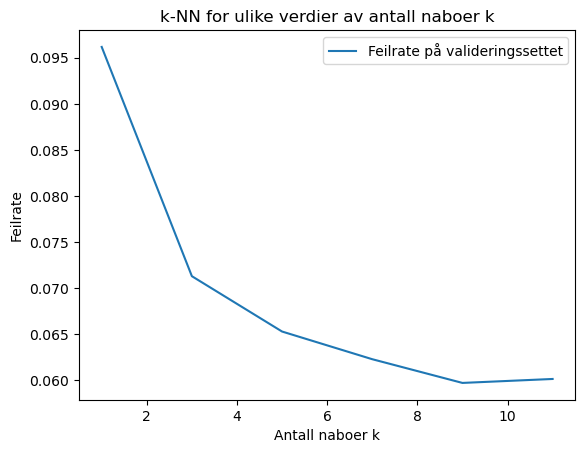

Valideringsfeilrate:
[[ 1.          0.09617862]
 [ 3.          0.07127523]
 [ 5.          0.06526406]
 [ 7.          0.06225848]
 [ 9.          0.05968227]
 [11.          0.06011164]]


In [29]:
knaboer = np.arange(1,12,step=2)
val_feilrate = np.empty(len(knaboer))


for i,k in enumerate(knaboer):
    
#Initialiser kNN med  k neighbors
    knn = KNeighborsClassifier(n_neighbors=k,p=2) # p=2 gir euklidsk avstand

# Tilpass modellen med treningssettet
    knn.fit(X_tren, df_tren['Purchase'])
    
# Beregn feilrate på valideringssett
# Score er accuracy= "andel korrekt"
    val_feilrate[i] = 1 - knn.score(X_val, df_val['Purchase'])
    
# Lage plott
plt.title('k-NN for ulike verdier av antall naboer k')
plt.plot(knaboer, val_feilrate, label='Feilrate på valideringssettet')
plt.legend()
plt.xlabel('Antall naboer k')
plt.ylabel('Feilrate')
plt.show()

valres=np.vstack((knaboer, val_feilrate))
print("Valideringsfeilrate:")
print(valres.T)

### Problem 2h) (2P)

(i)  Velg $k$ med den minste feilraten og beregn forvirringsmatrise for valideringssettet (bruke samme code some for $k=1$ oppover).

(ii)  Er det lurt å bruke denne $k$-verdien? Hvorfor (ikke)?
 
###   <font color='red'>Løsning:</font> Svar på svararket.